In [26]:
from PIL import Image

import matplotlib.pyplot as plt

import numpy as np
import torch

from propose.models.flows import CondGraphFlow
from propose.poses.human36m import Human36mPose, MPIIPose

%matplotlib inline

### Load in the pretrained model

In [81]:
flow = CondGraphFlow.from_pretrained("ppierzc/propose_human36m/mpii-prod:best")
flow.eval();

### Obtain 2D coordinates

cGNF is a lifting model, thus all it needs are the 2D coordinates to lift them to 3D

In [138]:
coords = np.array([2.8,107.31,12.729,56.932,16.294,-1.1565,-16.404,0.18427,-19.846,60.876,-29.314,114.55,0,-0,-2.5386,-33.103,10.724,-65.857,18.876,-87.54,39.14,-15.722,31.454,-12.768,24.829,-50.756,-10.648,-66.329,-28.272,-48.817,5.1322,-57.324])
coords = coords.reshape(1, 16, 2)

### Define the pose
With `propose` you can define the pose format. Here the 2D coordinates are in the MPII pose format

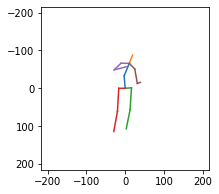

In [141]:
pose = MPIIPose(coords)

plt.figure(figsize=(3, 3))
pose.plot()
plt.xlim(-3 / 0.0139, 3 / 0.0139)
plt.ylim(3 / 0.0139, -3 / 0.0139)
plt.show()

Are there any occluded markers? In this case no.

In [142]:
pose.occluded_markers = np.zeros((1, 16, 1)).astype(bool)

Once the pose is set up we can convert it to the Human3.6M format using `propose` which is used by our cGNF

In [ ]:
pose_2d = pose.to_human36m()

We run preprocessing on the pose to prepare it for the cGNF model.

In [143]:
context_graph = flow.preprocess(pose_2d)

### Generate Samples
Now we can easily generate samples conditioned on the context graph

In [147]:
n_samples = 100

with torch.no_grad():
    samples = flow.sample(n_samples, context=context_graph)["x"]["x"]

We need to do some additional postprocessing to vizualize the poses nicely.

In [148]:
samples = samples.cpu().numpy()
samples = np.insert(samples, 0, 0, 0)
samples = samples.swapaxes(0, 1)

We now convert the samples into Human36m Pose for plotting. We add a median of the samples for visualization.

In [145]:
sampled_pose = Human36mPose(samples)
median_pose = Human36mPose(np.median(samples, axis=0))

### Plot the samples
With `propose` poses we can easily plot the samples. Simply using the `Human36mPose.plot` method.

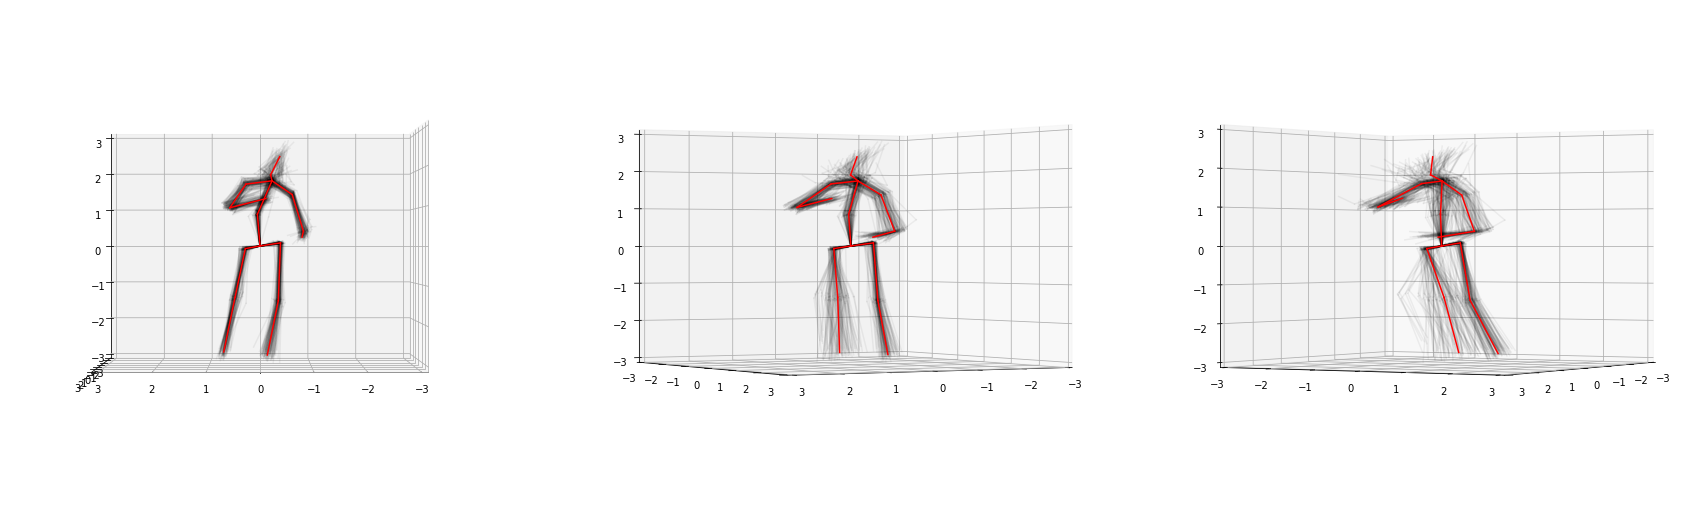

In [146]:
fig = plt.figure(figsize=(30, 10))
ax = plt.subplot(1, 3, 1, projection="3d")
ax.view_init(0, 90)
sampled_pose.plot(ax, plot_type="None", c="k", alpha=0.05)
median_pose.plot(ax, plot_type="None", c="r", alpha=1)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

ax = plt.subplot(1, 3, 2, projection="3d")
ax.view_init(0, 60)
sampled_pose.plot(ax, plot_type="None", c="k", alpha=0.05)
median_pose.plot(ax, plot_type="None", c="r", alpha=1)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

ax = plt.subplot(1, 3, 3, projection="3d")
ax.view_init(0, 30)
sampled_pose.plot(ax, plot_type="None", c="k", alpha=0.05)
median_pose.plot(ax, plot_type="None", c="r", alpha=1)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()